In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import birdsonganalysis as bsa
from os.path import join, exists
from scipy.io import wavfile
import pickle
import json
from pprint import pprint
from IPython.display import Audio, display

import sys

sys.path.append('../model/hillclimbing/')

from song_fitter import SongModel, get_scores
import synth

sns.set_palette('colorblind')

In [2]:
path = '../model/hillclimbing/res/170316_164031_big_ba/'
if exists(join(path, 'aborted.txt')):
    raise ValueError('Aborted run')

In [3]:
sr, tutor = wavfile.read(join(path, 'tutor.wav'))
with open(join(path, 'params.json'), 'r') as f:
    run_param = json.load(f)

In [4]:
pprint(run_param)

{'commit': '6a0b1623528035c1d2bb78e9cdf807b8d6e0dee2',
 'comp': 'linalg',
 'concurrent': 3,
 'days': 50,
 'iter_per_train': 20,
 'name': 'big_ba',
 'replay': 5,
 'seed': 1489678831,
 'train_per_day': 100,
 'tutor': '../../data/ba_example.wav'}


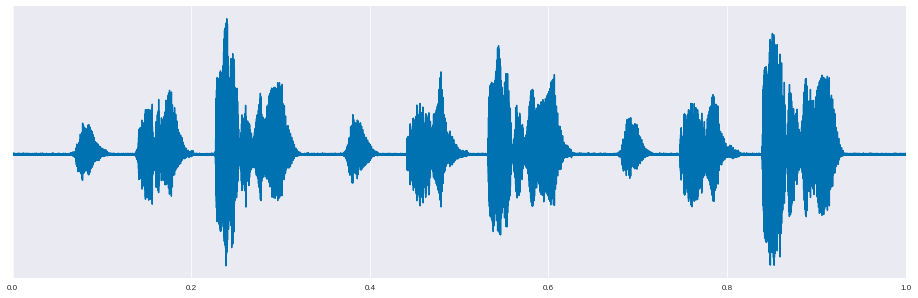

In [5]:
with sns.plotting_context('paper'):
    fig = plt.figure(figsize=(16, 5))
    ax = fig.gca()
    ax.plot(np.r_[0:len(tutor)//44100:len(tutor)*1j], tutor)
    ax.set_yticks([])
    ax.set_xlim((0, len(tutor)//44100))
    plt.show()

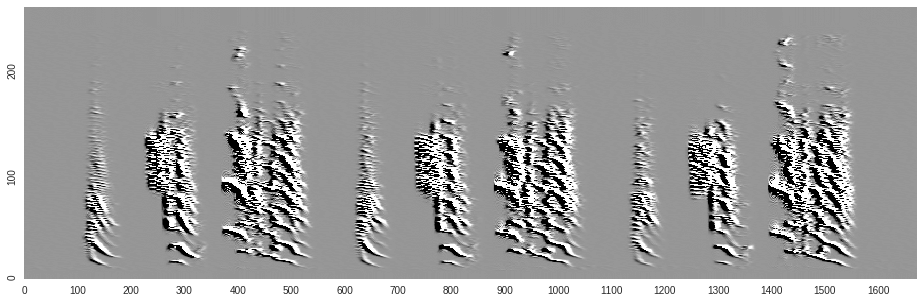

In [6]:
tspec = bsa.spectral_derivs(tutor, 256, 40, 1024)
fig = plt.figure(figsize=(16, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(tspec, contrast=0.01, ax=ax)
plt.show(fig)
plt.close(fig)

In [7]:
outputs = []
for i in range(run_param['concurrent']):
    outputs.append(wavfile.read(join(path, 'out_{}.wav'.format(i)))[1])

In [8]:
display(Audio(tutor, rate=44100))

In [9]:
for output in outputs:
    display(Audio(output, rate=44100))

In [10]:
run = False  # Disabled because very long.
if run:
    for out in outputs:
        sim = bsa.similarity(out, tutor)
        bsa.similarity_plot(sim, out, tutor)
        print(sim['similarity'])

In [11]:
tfeat = bsa.all_song_features(tutor, 44100)
sfeat = bsa.all_song_features(outputs[0], 44100)

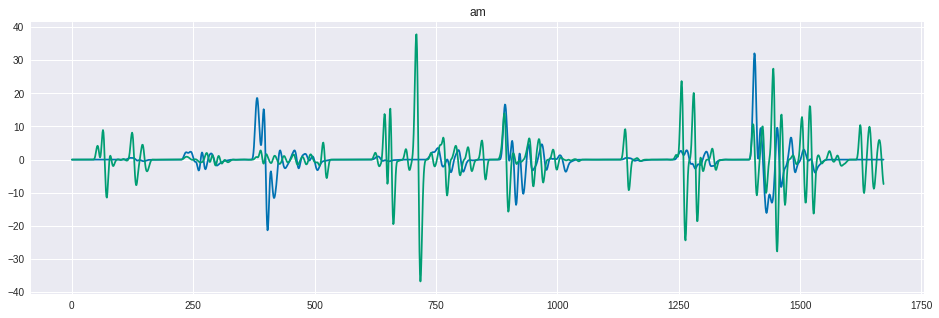

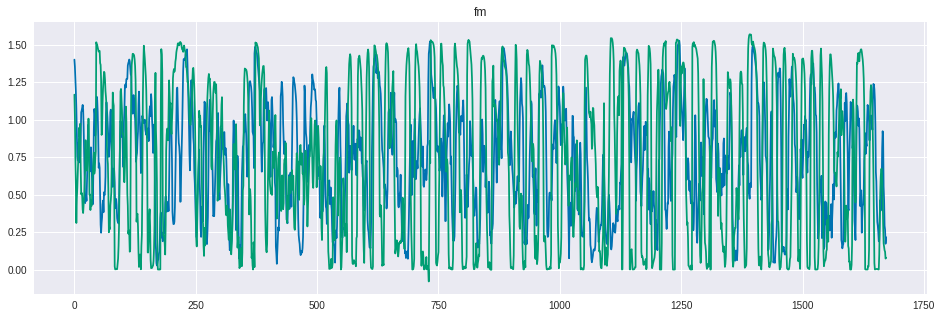

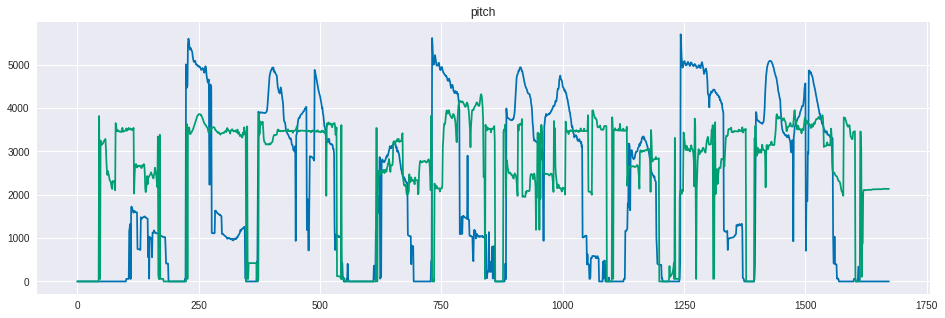

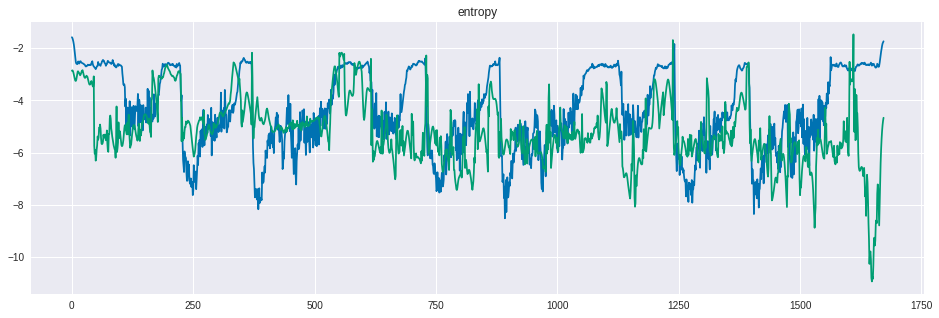

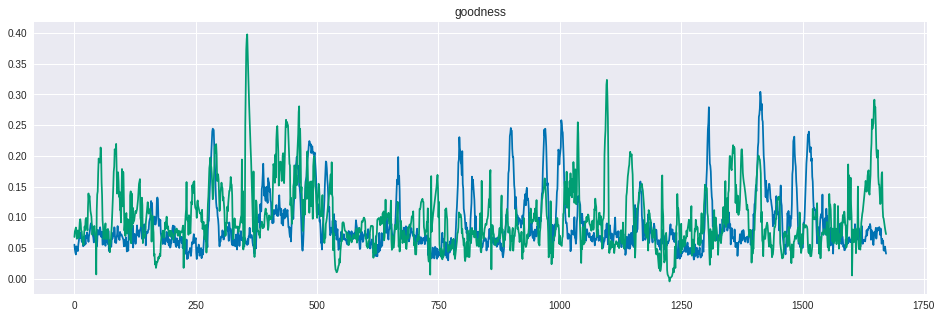

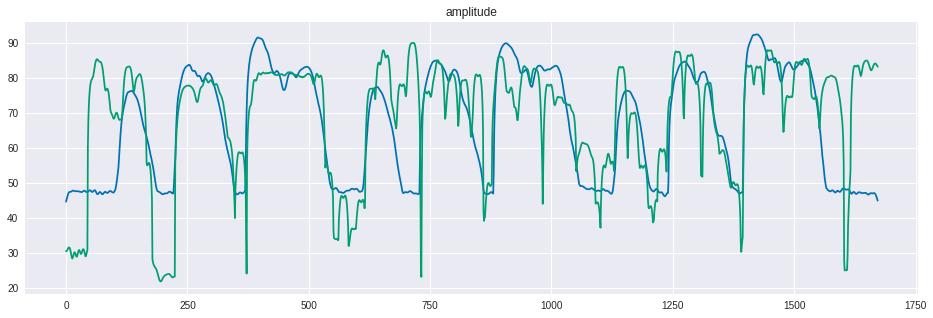

In [12]:
for fname in tfeat:
    plt.figure(figsize=(16, 5))
    plt.plot(tfeat[fname])
    plt.plot(sfeat[fname])
    plt.title(fname)
    plt.show()

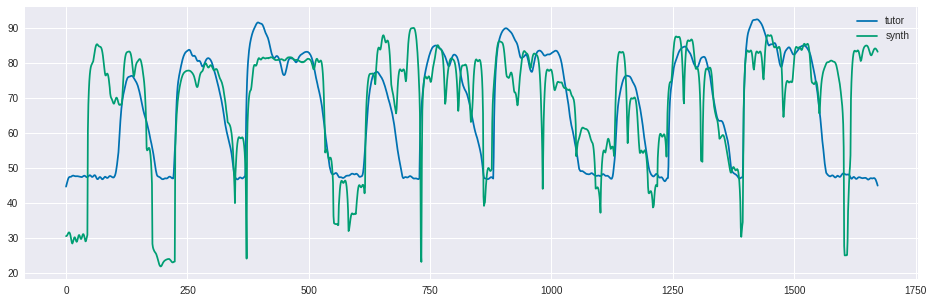

In [13]:
plt.figure(figsize=(16, 5))

plt.plot(tfeat['amplitude'], label="tutor")
plt.plot(sfeat['amplitude'], label="synth")
plt.legend()
plt.show()

In [14]:
with open(join(path, 'songs.pkl'), 'rb') as f:
    smodels = pickle.load(f)

In [15]:
len(smodels[1].gestures)

54

In [16]:
ab = []
for i, gesture in enumerate(smodels[0].gestures):
    p = gesture[1]
    start = gesture[0]
    try:
        end = smodels[0].gestures[i+1][0]
    except IndexError:
        end = len(tutor)
    size = end - start
    ab.append(synth.gen_alphabeta(p, size, falpha=lambda x, p: synth.only_sin(x, p, nb_sin=3),
                fbeta=lambda x, p: synth.only_sin(x, p, nb_sin=1),
                falpha_nb_args=13))
ab = np.concatenate(ab)

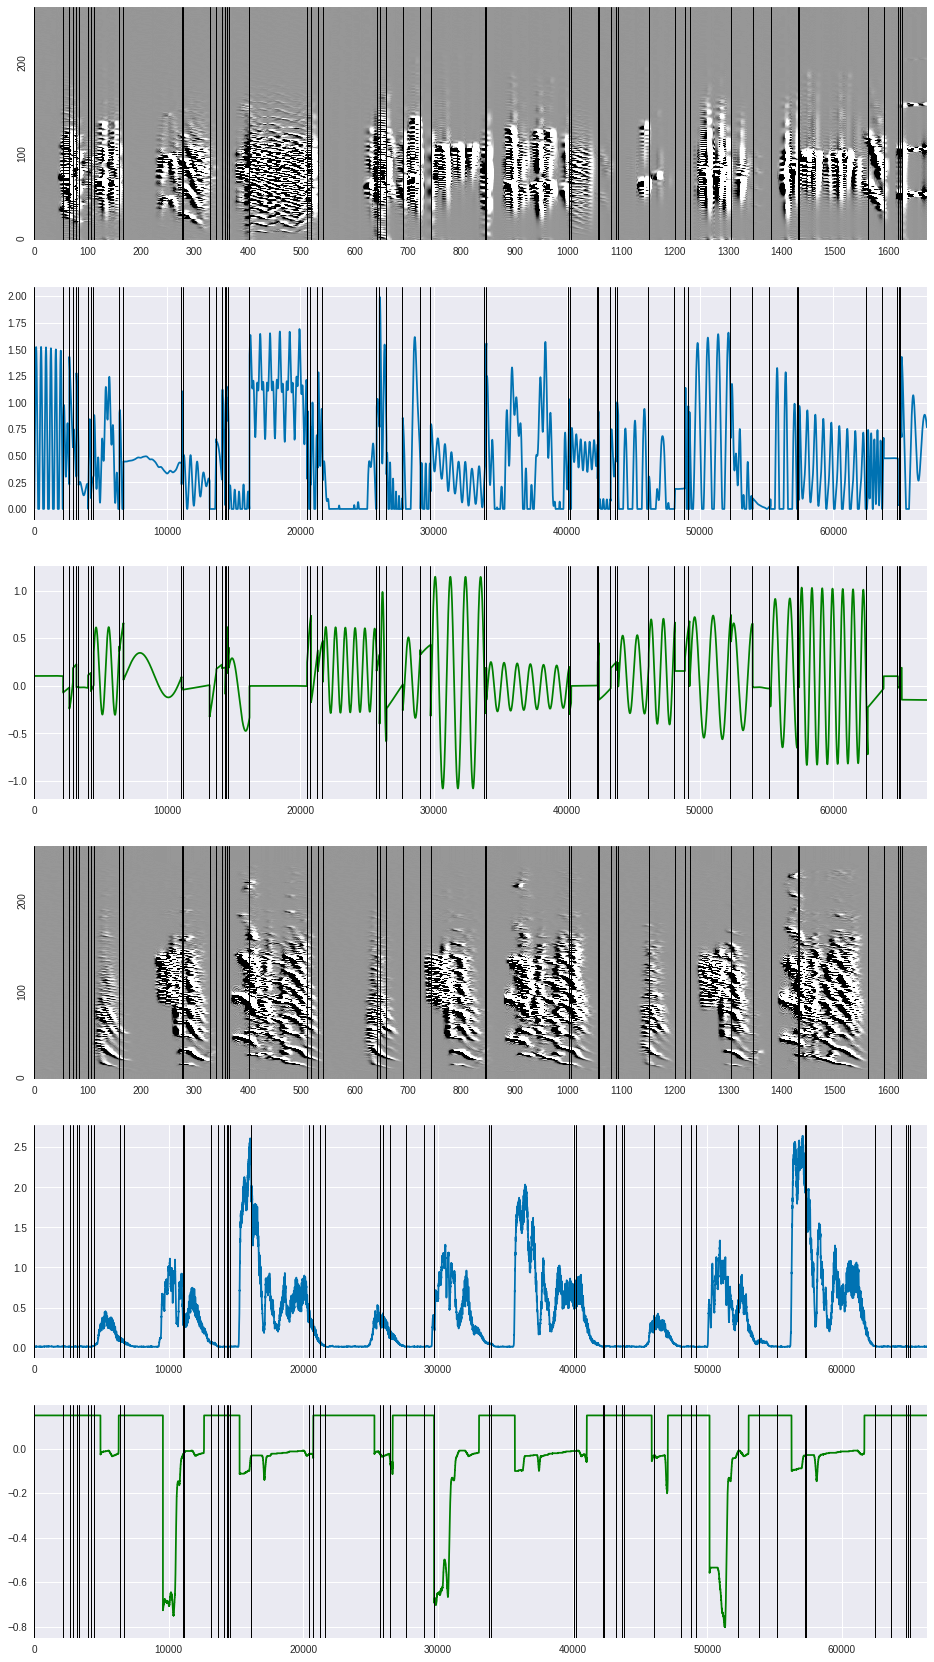

In [17]:
from os.path import basename


fig, axs = plt.subplots(6, 1, figsize=(16, 5*6))
ospec = bsa.spectral_derivs(outputs[0], 256, 40, 1024)
bsa.spectral_derivs_plot(ospec, contrast=0.01, ax=axs[0])
axs[0].set_xlim(0, ospec.shape[0])
axs[1].plot(ab[:, 0])
axs[1].set_xlim((0, ab.shape[0]))
axs[2].plot(ab[:, 1], color="g")
axs[2].set_xlim((0, ab.shape[0]))
bsa.spectral_derivs_plot(tspec, contrast=0.01, ax=axs[3])

tutor_params = np.loadtxt('../data/{}_ab.dat'.format(basename(run_param['tutor']).split('.')[0]))
axs[4].plot(tutor_params[:, 0])
axs[4].set_xlim((0, tutor_params.shape[0]))
axs[5].plot(tutor_params[:, 1], c="g")
axs[5].set_xlim((0, tutor_params.shape[0]))


for i, gesture in enumerate(smodels[0].gestures):
    start = gesture[0]
    axs[0].axvline(x=start/40, color="k", linewidth=1)
    axs[1].axvline(x=start, color="k", linewidth=1)
    axs[2].axvline(x=start, color="k", linewidth=1)
    axs[3].axvline(x=start/40, color="k", linewidth=1)
    axs[4].axvline(x=start, color="k", linewidth=1)
    axs[5].axvline(x=start, color="k", linewidth=1)

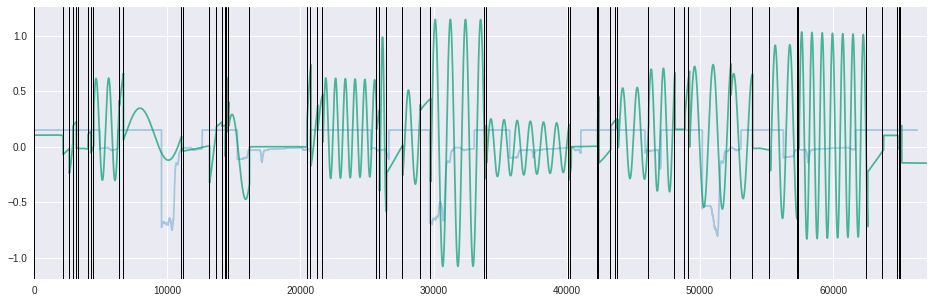

In [18]:
plt.figure(figsize=(16, 5))
plt.plot(tutor_params[:, 1], alpha=0.3)
plt.plot(ab[:, 1], alpha=0.7)
plt.xlim(0, ab.shape[0])
for i, gesture in enumerate(smodels[0].gestures):
    start = gesture[0]
    plt.axvline(x=start, color="k", linewidth=1)

In [19]:
gtes = np.loadtxt('../data/{}_gte.dat'.format(basename(run_param['tutor']).split('.')[0]))
true_gtes = gtes[np.concatenate(((np.diff(gtes) > 100), (False,)))]

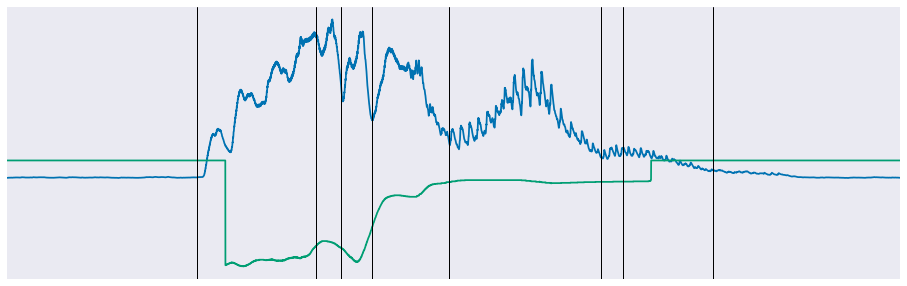

In [20]:
plt.figure(figsize=(16, 5))
plt.plot(np.arange(28000, 35000), tutor_params[28000:35000])
#plt.plot(ab[:, 0], alpha=0.5)
plt.xlim(28000, 35000)
plt.xticks([])
plt.yticks([])
for gte in true_gtes:
    start = gesture[0]
    plt.axvline(x=gte, color="k", linewidth=1)

In [21]:
len(true_gtes)

65

In [22]:
np.mean(np.diff(true_gtes))

881.453125

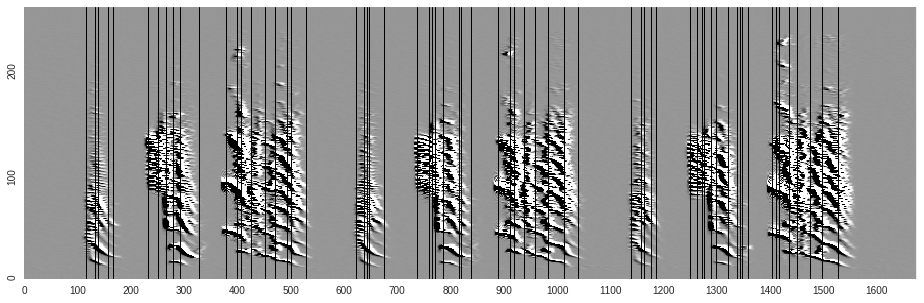

In [23]:
fig = plt.figure(figsize=(16, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(tspec, contrast=0.01, ax=ax)
ax.set_xlim(0, ab.shape[0]/40)
for gte in true_gtes:
    ax.axvline(x=gte/40, color="k", linewidth=1)

# Analysis of the song log

In [24]:
with open(join(path, 'data.pkl'), 'rb') as f:
    songlog = pickle.load(f)

In [25]:
import pandas

In [26]:
root_data = [item[1] for item in songlog if item[0] == 'root']

In [27]:
rd = pandas.DataFrame(root_data)

In [28]:
rd['songs'][0]

In [29]:
day_opt = pandas.DataFrame([elem[1] for elem in songlog if elem[0] == 'day_optim'])

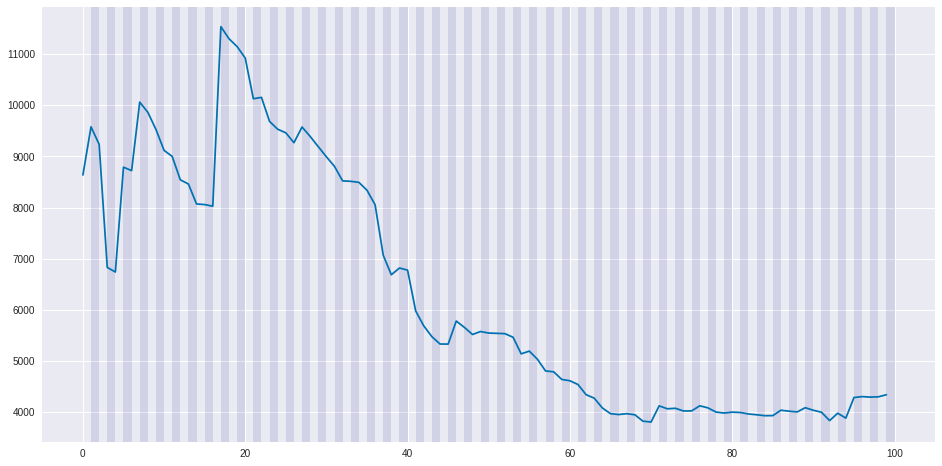

In [30]:
plt.figure(figsize=(16, 8))
for i in range(1, len(rd['scores']), 2):
    plt.axvspan(i, i+1, facecolor='darkblue', alpha=0.1)
plt.plot(rd['scores'].apply(np.min))
#plt.xticks(range(len(rd['scores'])), rd['moment'], rotation=75)
plt.show()

(120, 160)

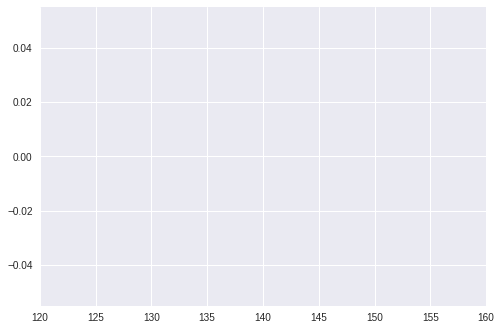

In [31]:
beg = 120
end = 160
plt.plot(rd['scores'][beg:end].apply(np.min))
for i in range(1, len(rd['scores']), 2):
    plt.axvspan(i, i+1, facecolor='darkblue', alpha=0.1)
plt.xlim((beg, end))

In [32]:
np.median(np.array(rd['scores'].apply(np.min)[2::2]) - np.array(rd['scores'].apply(np.min)[1:-2:2]))

-82.152245821532688

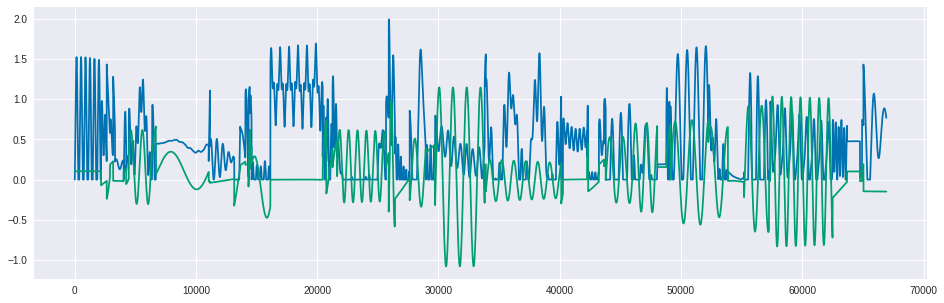

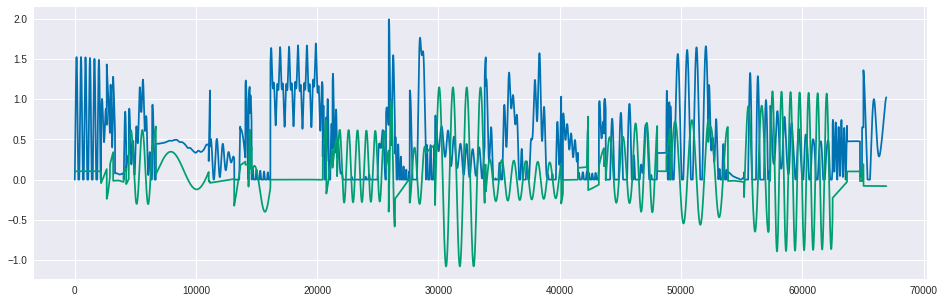

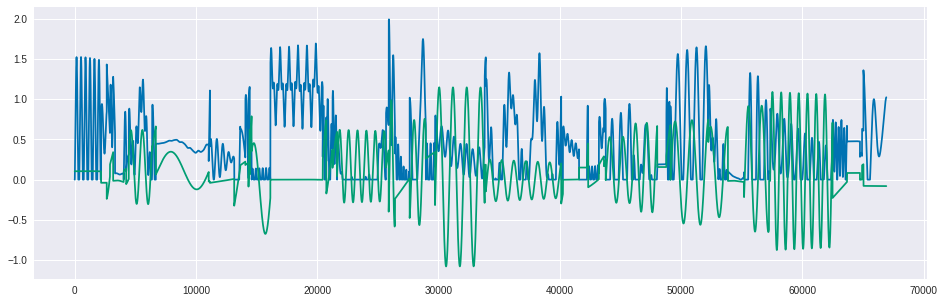

In [33]:
for i in range(len(rd['songs'].iloc[-1])):
    plt.figure(figsize=(16, 5))
    plt.plot(rd['songs'].iloc[-1][i].gen_alphabeta())

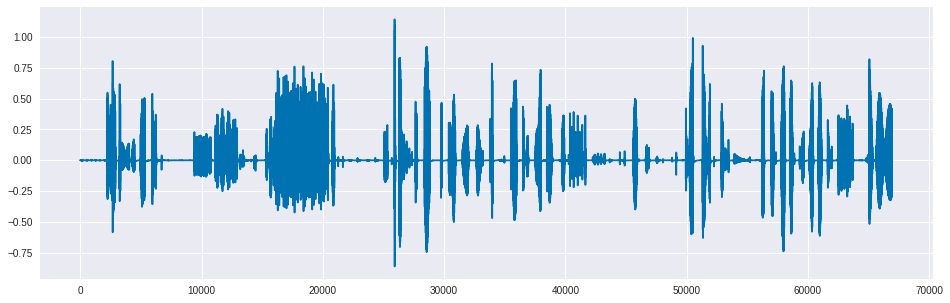

In [34]:
plt.figure(figsize=(16, 5))
plt.plot(rd['songs'].iloc[-1][0].gen_sound())

In [35]:
from synth import synthesize
s = rd['songs'].iloc[-1][0].gen_alphabeta()
Audio(synthesize(s), rate=44100)

In [36]:
Audio(synthesize(tutor_params), rate=44100)

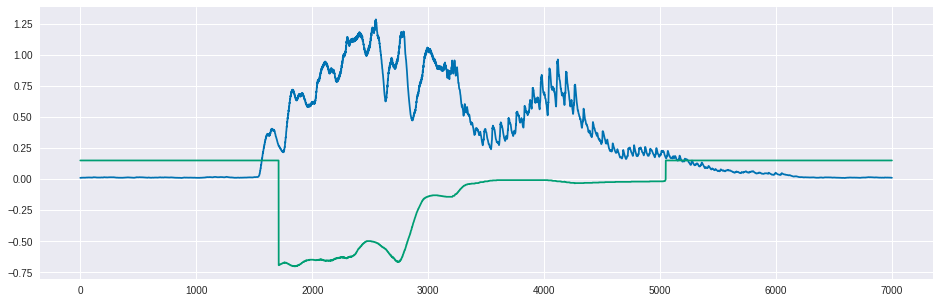

In [37]:
plt.figure(figsize=(16, 5))
plt.plot(tutor_params[28000:35000])